In [1]:
import datetime
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ROOT_DIR = str(Path().resolve().parent)

sys.path.append('../')
plt.style.use(f'./project.mplstyle')

In [2]:
import importlib.resources
importlib.resources.path("asd", "hmm/hmm_signal_peptide.joblib")
    

# Genomes to Growth Conditions

In [8]:
prefix = "GCA_000172155.1_ASM17215v1"
contig_filepath = f"../tests/test_data/{prefix}_genomic.fna.gz"
protein_filepath = f"../tests/test_data/{prefix}_protein.faa.gz"

# prefix = "GCA_016767175.1_ASM1676717v1"
# prefix ="GCA_900096925.1_IMG-taxon_2616645037_annotated_assembly"
# contig_filepath = f"../data/genomes/genbank/bacteria/{'_'.join(prefix.split('_')[0:2])}/{prefix}_genomic.fna.gz"
# protein_filepath = f"../data/genomes/genbank/bacteria/{'_'.join(prefix.split('_')[0:2])}/{prefix}_protein.faa.gz"

## Predict Growth Conditions



In [4]:
from genome_spot.genome_spot import GenomeSPOT, run_genome_spot

print(datetime.datetime.now())
predictions, genome_features = run_genome_spot(
        fna_path=contig_filepath,
        faa_path=protein_filepath,
        features_json=None,
        path_to_models=f"../models",
        #save_intermediate=False,
    )
print(datetime.datetime.now())

pd.DataFrame(predictions).T.sort_index()

2024-03-17 15:35:24 INFO Measuring features from:
	../data/genomes/genbank/bacteria/GCA_900096925.1/GCA_900096925.1_IMG-taxon_2616645037_annotated_assembly_genomic.fna.gz
	../data/genomes/genbank/bacteria/GCA_900096925.1/GCA_900096925.1_IMG-taxon_2616645037_annotated_assembly_protein.faa.gz
2024-03-17 15:35:24 INFO GCA_900096925.1_IMG-taxon_2616645037_annotated_assembly_genomic.fna.gz: Identifying protein localization


2024-03-17 15:35:24.699899


2024-03-17 15:35:26 INFO GCA_900096925.1_IMG-taxon_2616645037_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-17 15:35:27 INFO GCA_900096925.1_IMG-taxon_2616645037_annotated_assembly_genomic.fna.gz: Collecting protein statistics
2024-03-17 15:35:27 INFO Predicting growth conditions


2024-03-17 15:35:27.137258


,value,error,is_novel,warning,units
oxygen,tolerant,0.831445,False,None,probability
ph_max,9.339235,1.231827,False,None,pH
ph_min,5.854202,0.919082,False,None,pH
ph_optimum,7.608927,0.884935,False,None,pH
salinity_max,7.855166,4.017368,False,None,% w/v NaCl
salinity_min,2.206405,2.307733,False,None,% w/v NaCl
salinity_optimum,3.10798,2.446439,False,None,% w/v NaCl
temperature_max,45.18426,6.235459,False,None,C
temperature_min,18.253843,7.838025,False,None,C
temperature_optimum,34.09345,6.072984,False,None,C


## Measure Genome Properties

### 1 Protein Sequence

In [6]:
from genome_spot.bioinformatics.protein import Protein

sequence = ''.join("""MAAQDVKQQTPYRVIQLEWDAEKGERNEAVGNFDELVTHHPKSNSDAHLVDGKVVGGQAG
RTLGVVGGEIQEIEVSKAGKDYGLRPDQVLLKKDFMLEDSRLPSGPSSRSLDVPSPVAGV
VGTVNTSKGLVDVLDREGGDVILRVRHMSPLHVKAGDQVEYGQALGVQGKQATGAIHVHM
EVDSRYYQHYENYVGDLVSGRLSIDAERRDRGIEPRPFVDDGTIRIGGSSEMVQKVQQTL
NAEGYRGADNQPLQEDGVYRLSMQAAVINYQQAHGLSQTGDIDPATLQQIAPRTFPPELN
REDHNATPTYRNLQGAVPSQDPLHRQAEEDVRRLEQSLGRDYDDNSARLAASSAHLAKAN
GLTQIDHVVLSNQTAAVGKGENVFVVQGALDNPAHLMAHMKTSDAIAQPVEQSLSQLQTL
SETQRQQQAQQQSQQQDQQQLSAPQHRMV""".split('\n'))

protein = Protein(sequence)
protein.protein_metrics()

{'pi': 5.382106971740723,
 'zc': 0.19821826280623608,
 'nh2o': 0.07137639198218272,
 'gravy': -0.6514476614699332,
 'thermostable_freq': 0.356347438752784,
 'length': 449,
 'is_exported': False,
 'aa_M': 0.0200445434298441,
 'aa_A': 0.08463251670378619,
 'aa_Q': 0.10690423162583519,
 'aa_D': 0.0757238307349666,
 'aa_V': 0.0935412026726058,
 'aa_K': 0.0334075723830735,
 'aa_T': 0.0400890868596882,
 'aa_P': 0.0467706013363029,
 'aa_Y': 0.026726057906458798,
 'aa_R': 0.062360801781737196,
 'aa_I': 0.031180400890868598,
 'aa_L': 0.08240534521158129,
 'aa_E': 0.05790645879732739,
 'aa_W': 0.0022271714922048997,
 'aa_G': 0.08685968819599109,
 'aa_N': 0.035634743875278395,
 'aa_F': 0.011135857461024499,
 'aa_H': 0.035634743875278395,
 'aa_S': 0.066815144766147}

### 1 Signal Peptide Prediction

In [7]:
from genome_spot.bioinformatics.signal_peptide import SignalPeptideHMM

partial_sequence = 'MNKTLIAAAVAGIVLLASNAQAQTVPEGYQLQQVLMMSRHNLRAPLANNG'

signal_peptide_model = SignalPeptideHMM()
is_exported, signal_end_index = signal_peptide_model.predict_signal_peptide(partial_sequence)
signal_peptide = partial_sequence[:signal_end_index+1]
is_exported, signal_peptide

(True, 'MNKTLIAAAVAGIVLLASNAQA')

In [8]:
formatted_sequence = signal_peptide_model._format_protein_sequence(partial_sequence)
pred_states, log_prob = signal_peptide_model._predict_hidden_states(formatted_sequence)
print(log_prob)
for aa, state in zip(partial_sequence[:len(formatted_sequence)], pred_states):
    print(aa,state)

-130.73482767354764
M B
N N3
K N2
T N1
L H
I H
A H
A H
A H
V H
A H
G H
I H
V H
L H
L H
A H
S C
N C
A C3
Q C2
A C1
Q M
T M
V M
P M
E M
G M
Y M
Q M
L M
Q M
Q M
V M
L M
M M
M M
S M
R M
H M
N M
L M
R M
A M
P M
L M
A M
N M
N M
G M


### 1 DNA Sequence


In [9]:
from genome_spot.bioinformatics.dna import DNA

sequence = "GGATGGACGGAGGAATTCCTCAAGGAAGTCGGGCCCGCGCTGGTGGTACTCGGTCCAGGCTTCTTGCACGAAGAAGTCTCCGACCGCGCCTCTCTCCACCCTCCTGGCAAAATCGGCCAGTGACTTGATGCCGATGTGGTAGATGAAGCCGGTGTCGAGTACGCCCTTGGCGAAGGTCGGGTCCGCCAGCCTCTCGGGAAAATTTTCTTCGATGTTCAGATAGTAGCCGCGCATGCTGACGCCACGGCTATCTAAAGTGAACATTCCGTCCTTCAGAATGCAATCGGCATGGTGCCAAAATCCAGAGCCCACCGCGCTGGCAATCTTGTTGTCGTCAACTGCGTCGGATCGGACGAGGCACTTCGTGAACGGCGCCGGCAATTCGGACCGTCGAGTGTAATTACGGATTGCGGACCCAGACGGGCGCGTGGCGTGGCCGTTATGCCCAGCATTGACGGAGAACAGGTGGATTGCCCCCACTCCACCCGGAAAGCGTGAGATAAACTCTCGGATCGTGTCGTCGTTGCGCAGTAAAATAAATTCGTCAACATCGAGAAATATGTAATTACGGCTCAGATGTTTAAA"
dna = DNA(sequence)
dna.nucleotide_metrics()

{'nt_length': 585,
 'pur_pyr_transition_freq': 0.4897260273972603,
 'nt_C': 0.558974358974359,
 'nt_A': 0.441025641025641}

In [10]:
DNA("ACTAGCGACTAGC").nucleotide_metrics()

{'nt_length': 13,
 'pur_pyr_transition_freq': 0.5833333333333334,
 'nt_A': 0.46153846153846156,
 'nt_C': 0.5384615384615384}

### All Protein and DNA Sequences

Note: It is expected and good to see NaN for many features because they cannot be computed by cellular localization.

In [11]:
from genome_spot.bioinformatics.genome import Genome
from genome_spot.bioinformatics.signal_peptide import SignalPeptideHMM

genome_calc = Genome(
    contig_filepath=contig_filepath, 
    protein_filepath=protein_filepath,
)

print(datetime.datetime.now())
genome_features = genome_calc.measure_genome_features()
print(datetime.datetime.now())

2024-03-15 15:37:22 INFO GCA_000172155.1_ASM17215v1_genomic.fna.gz: Identifying protein localization


2024-03-15 15:37:22.581463


2024-03-15 15:37:25 INFO GCA_000172155.1_ASM17215v1_genomic.fna.gz: Collecting genome statistics
2024-03-15 15:37:26 INFO GCA_000172155.1_ASM17215v1_genomic.fna.gz: Collecting protein statistics


2024-03-15 15:37:27.009166


In [12]:
df_genome = pd.DataFrame(genome_features)
df_genome.head(30)

,all,extracellular_soluble,intracellular_soluble,membrane,diff_extra_intra
nt_length,8.220859e+06,NaN,NaN,NaN,NaN
pur_pyr_transition_freq,4.796972e-01,NaN,NaN,NaN,NaN
nt_C,6.031152e-01,NaN,NaN,NaN,NaN
nt_A,3.968848e-01,NaN,NaN,NaN,NaN
total_proteins,6.519000e+03,635.000000,5.336000e+03,548.000000,-4.701000e+03
total_protein_length,2.366909e+06,285520.000000,1.921398e+06,159991.000000,-1.635878e+06
pis_acidic,1.988035e-01,0.215748,2.113943e-01,0.056569,4.353729e-03
pis_neutral,4.914864e-01,0.615748,5.018741e-01,0.246350,1.138740e-01
pis_basic,3.097101e-01,0.168504,2.867316e-01,0.697080,-1.182277e-01
pis_3_4,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00


### All Proteins

In [13]:
protein_data = genome_calc.protein_data()
df_proteins = pd.DataFrame(protein_data).T
df_proteins

,pi,zc,nh2o,gravy,thermostable_freq,length,is_exported,aa_M,aa_S,aa_L,...,aa_C,aa_G,aa_A,aa_H,aa_E,aa_R,aa_Q,aa_N,aa_F,aa_W
ABIZ01000001.1_1,7.551992,-0.179457,0.014524,-0.33754,0.386581,626,False,0.025559,0.059105,0.089457,...,0.015974,0.08147,0.087859,0.017572,0.070288,0.063898,0.044728,0.031949,0.031949,0.01278
ABIZ01000001.1_2,11.364825,-0.744643,0.070964,0.251786,0.464286,56,False,0.017857,0.089286,0.125,...,0.017857,0.107143,0.089286,0.017857,0.017857,0.107143,NaN,0.035714,0.017857,0.035714
ABIZ01000001.1_3,6.49581,-0.276424,-0.020354,-0.144702,0.39404,302,False,0.023179,0.046358,0.112583,...,0.016556,0.092715,0.096026,0.043046,0.062914,0.05298,0.019868,0.039735,0.029801,0.013245
ABIZ01000001.1_4,6.166826,-0.120446,-0.054786,-0.380501,0.395543,359,False,0.022284,0.061281,0.094708,...,0.011142,0.075209,0.075209,0.038997,0.066852,0.064067,0.030641,0.050139,0.038997,0.011142
ABIZ01000001.1_5,5.399329,-0.281062,0.052735,-0.257522,0.411504,226,False,0.00885,0.070796,0.132743,...,0.022124,0.070796,0.110619,0.00885,0.070796,0.084071,0.053097,0.017699,0.030973,0.022124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ABIZ01000001.1_6515,9.24749,-0.947007,-0.111161,0.443796,0.394161,137,False,0.043796,0.051095,0.109489,...,0.007299,0.072993,0.153285,0.014599,0.021898,0.065693,0.029197,0.007299,0.058394,0.029197
ABIZ01000001.1_6516,8.159264,0.033143,0.083814,-0.695714,0.414286,70,False,0.014286,0.057143,0.114286,...,NaN,0.057143,0.057143,0.042857,0.1,0.071429,0.071429,0.057143,0.028571,NaN
ABIZ01000001.1_6517,5.395009,-0.4275,0.021831,-0.223529,0.433824,136,False,0.036765,0.051471,0.132353,...,0.029412,0.095588,0.066176,0.014706,0.080882,0.095588,0.051471,0.014706,0.029412,0.022059
ABIZ01000001.1_6518,4.872716,-0.37697,-0.011582,-0.013636,0.4,330,False,0.045455,0.060606,0.075758,...,0.024242,0.078788,0.087879,0.021212,0.075758,0.054545,0.018182,0.036364,0.036364,0.015152


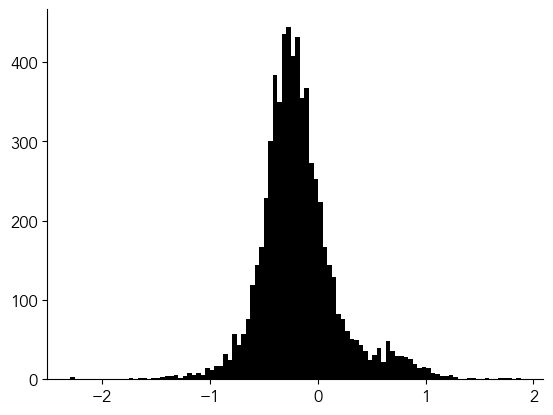

In [14]:
x = 'gravy'

X = df_proteins[x].values 

fig, ax = plt.subplots()
ax.hist(X, bins=100)
#ax.axvline(0.5)

plt.show()

# Datasets for Training and Testing

## Balancing a Dataset by Taxonomy

Removes genomes from taxonomic lineages overrepresented in the dataset relative to Genome Taxonomy Database representative species

In [15]:
# Download taxonomy files
from genome_spot.taxonomy.taxonomy import TaxonomyGTDB
taxonomy = TaxonomyGTDB()

{k:v for n, (k, v) in enumerate(taxonomy.taxonomy_dict.items()) if n < 2}

{'GCA_000979555': ('Archaea',
  'Halobacteriota',
  'Methanosarcinia',
  'Methanosarcinales',
  'Methanosarcinaceae',
  'Methanosarcina',
  'Methanosarcina mazei'),
 'GCA_001315865': ('Archaea',
  'Halobacteriota',
  'Methanosarcinia',
  'Methanosarcinales',
  'Methanosarcinaceae',
  'Methanosarcina',
  'Methanosarcina mazei')}

In [19]:

from genome_spot.taxonomy.balance import BalanceTaxa

with open("../tests/test_data/test_genome_accessions.txt", 'r') as fh:
    genomes = [line.strip() for line in fh.readlines()]

taxonomy = TaxonomyGTDB()
balancer = BalanceTaxa(taxonomy=taxonomy)
balanced_genomes = balancer.balance_dataset(
    genomes=genomes,
    proportion_to_keep=0.5,
    diversity_rank="species"
)
len(balanced_genomes) / len(genomes)

0.5

In [23]:
# It's reproducibly random

balanced_genomes1 = BalanceTaxa(taxonomy=taxonomy).balance_dataset(
    genomes=genomes,
    proportion_to_keep=0.5,
    diversity_rank="species"
)

balanced_genomes2 = BalanceTaxa(taxonomy=taxonomy).balance_dataset(
    genomes=genomes,
    proportion_to_keep=0.5,
    diversity_rank="species"
)

set(balanced_genomes1).difference(balanced_genomes2)

set()

## Test-Train Partition (Split) by Taxonomy

Use balanced genomes

NOTE: The script `make_holdout_sets.py` uses information from the variables themselves to decide which genomes to include and exclude for each condition. For simplicity, here only phylogeny is used and the growth condition is not considered.

In [24]:
from genome_spot.taxonomy.partition import PartitionTaxa

test_set = partitioner.partition(balanced_genomes, partition_size=0.2)
train_set = sorted(set(balanced_genomes).difference(test_set))

print(len(test_set) / len(balanced_genomes), len(train_set) / len(balanced_genomes))

0.2 0.8
20 30920


In [7]:
# It's reproducibly random
partitioned_genomes1 = partitioner.partition(balanced_genomes, partition_size=0.2)
partitioned_genomes2 = partitioner.partition(balanced_genomes, partition_size=0.2)
partitioned_genomes1 == partitioned_genomes2

NameError: name 'partitioner' is not defined

In [ ]:
# Some helpers to look up stuff
extended_partitioned_genomes = sorted(partitioner.find_relatives_of_partitioned_set_in_reference(test_set))
print(len(test_set), len(extended_partitioned_genomes))

In [27]:
# check for data leakage
partitioned_taxa = set(taxonomy.taxa_of_genomes(partitioned_genomes, partitioner.partition_rank))
nonpartitioned_taxa = set(taxonomy.taxa_of_genomes(nonpartitioned_genomes, partitioner.partition_rank))
assert len(partitioned_taxa.intersection(nonpartitioned_taxa)) == 0

# check partitioned genomes all present
len(set(partitioned_genomes).intersection(set(extended_partitioned_genomes))) == len(set(partitioned_genomes))
assert len(set(partitioned_genomes).difference(set(extended_partitioned_genomes))) == 0
print('Good!')

Good!


In [6]:
proportion_dict = balancer.assess_proportion(subset_genomes=test_set, reference_genomes=test_set.union(train_set), rank='phylum')
test_diversity = taxonomy.measure_diversity(query_rank='family', diversity_rank='species', subset_genomes=list(test_set))
train_diversity = taxonomy.measure_diversity(query_rank='family', diversity_rank='species', subset_genomes=list(train_set))

fig, axes = plt.subplots(1,2, figsize=(12,3),gridspec_kw={'width_ratios' : (3,1)})
test_color = 'tomato'
train_color = 'skyblue'
ax = axes[0]
df_counts = pd.DataFrame.from_dict(proportion_dict, orient='index').sort_index()
df_counts.columns = ['Test']
df_counts['Train'] = 1 - df_counts['Test']
ax.set_title(f"Distribution of Species by Partition across Phyla", fontsize=10)
df_counts.plot.bar(ax=ax, width=1, color=[test_color, train_color], edgecolor='None', stacked=True, legend=False)
ax.set_ylim([0,1])
ax.set_xlim([-0.5,ax.get_xlim()[1]-0.45])

ax = axes[1]
X1 = [0] + list(pd.DataFrame.from_dict(test_diversity, orient='index').sort_values(by=0, ascending=False)[0].values)
X2 = [0] + list(pd.DataFrame.from_dict(train_diversity, orient='index').sort_values(by=0, ascending=False)[0].values)
ax.set_title(f"Distribution of Species across Families", fontsize=10)
ax.plot(range(len(X1)), np.cumsum(X1) / np.sum(X1), marker='.', color=test_color, label='Test')
ax.plot(range(len(X2)), np.cumsum(X2) / np.sum(X2), marker='.', color=train_color, label='Train')
ax.set_ylabel('Cumulative Genomes')
ax.set_xlabel('Family')
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlim([0,ax.get_xlim()[1]])

for ax in axes:
    ax.legend(frameon=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.show() 

NameError: name 'balancer' is not defined

## Creating Cross-Validation Sets by Taxonomy

The test set is your final **final** look at the model quality. You should use cross-valdation (look it up) to evaluate and improve models. 

In [30]:
# As run in this function:
# from genome_spot.model_training.make_holdout_sets import make_cv_sets_by_phylogeny
# cv_sets = make_cv_sets_by_phylogeny(genomes=np.array(list(balanced_genomes)), partition_rank='order', kfold = 10)

genomes = train_set
kfold = 5
partitioner = PartitionTaxa(
        taxonomy=TaxonomyGTDB(),
        partition_rank='family',
        diversity_rank="species",
    )

cv_sets = []  # training, validation
remaining_genomes = set(genomes)
fold_sizes = []
for k in range(kfold):
    validation_partition_size = 1 / (kfold - k)
    partitioned_genomes = partitioner.partition(remaining_genomes, partition_size=validation_partition_size)
    if k < kfold - 1:
        remaining_genomes = set(remaining_genomes).difference(partitioned_genomes)
    else:
        partitioned_genomes = remaining_genomes
    validation_indices = np.in1d(genomes, np.array(list(partitioned_genomes))).nonzero()[0]
    training_indices = np.in1d(genomes, np.array(list(set(genomes).difference(partitioned_genomes)))).nonzero()[0]
    cv_sets.append((training_indices, validation_indices))
    fold_sizes.append(len(partitioned_genomes) / len(genomes))

    print(f"Fold {k+1}")
    print(f"{len(training_indices)} genomes in training")
    print(f"{len(validation_indices)} genomes in validation")
    print(f"{len(partitioned_genomes) / len(genomes)} fraction held out")
    print()


Fold 1
64 genomes in training
16 genomes in validation
0.2 fraction held out

Fold 2
62 genomes in training
18 genomes in validation
0.225 fraction held out

Fold 3
64 genomes in training
16 genomes in validation
0.2 fraction held out

Fold 4
65 genomes in training
15 genomes in validation
0.1875 fraction held out

Fold 5
65 genomes in training
15 genomes in validation
0.1875 fraction held out



## BacDive Trait Data
### Download Trait Data from BacDive API

In [31]:
from genome_spot.model_training.download_trait_data import QueryBacDive

credentials_filepath = f'../../.bacdive_credentials'

with open(credentials_filepath) as fh:
    username = fh.readline().strip()
    password = fh.readline().strip()


min_bacdive_id = 100
max_bacdive_id = 200
bacdive_dict = QueryBacDive(
            username=username, password=password,
            max_bacdive_id=int(max_bacdive_id),
            min_bacdive_id=int(min_bacdive_id),
        ).scrape_bacdive_api()

strain_ids = list(bacdive_dict.keys())
strain_data = bacdive_dict[strain_ids[0]]
strain_data.keys()

2024-03-15 15:39:45 INFO Logging into BacdiveClient
2024-03-15 15:39:47 INFO Iniating 100 queries in 1 chunks


-- Authentication successful --


2024-03-15 15:39:50 INFO Searching query indices 0-100 returned 100 results


dict_keys(['General', 'Name and taxonomic classification', 'Morphology', 'Culture and growth conditions', 'Physiology and metabolism', 'Isolation, sampling and environmental information', 'Safety information', 'Sequence information', 'Genome-based predictions', 'External links', 'Reference'])

### Parse Trait Data

In [32]:
from genome_spot.model_training.download_trait_data import ComputeBacDiveTraits

strain_data = bacdive_dict[strain_ids[2]]
strain_traits = ComputeBacDiveTraits(strain_data).compute_trait_data()
strain_traits

{'ncbi_accession': 'GCA_900475915.1',
 'ncbi_taxid': 644284,
 'strain_id': 197,
 'species': 'Arcanobacterium haemolyticum',
 'ph_optimum': None,
 'ph_optimum_min': None,
 'ph_optimum_max': None,
 'temperature_optimum': 37.0,
 'salinity_optimum': None,
 'salinity_midpoint': None,
 'salinity_min': None,
 'salinity_max': None,
 'ph_min': None,
 'ph_max': None,
 'temperature_min': 37.0,
 'temperature_max': 37.0,
 'oxygen': 1,
 'use_ph': False,
 'use_temperature': False,
 'use_salinity': False,
 'use_oxygen': True,
 'aerobe': None,
 'anaerobe': 1,
 'microaerophile': None,
 'facultative anaerobe': 1,
 'obligate aerobe': None,
 'obligate anaerobe': None,
 'facultative aerobe': None,
 'aerotolerant': None,
 'microaerotolerant': None}